<a href="https://colab.research.google.com/github/evansnjagi/AirQuality-analysis-in-Nairobi-Kenya/blob/main/AirQuality_in_Nairobi_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **AIRQUALITY ANALYSIS IN NAIROBI KENYA**

In [304]:
from PIL import Image

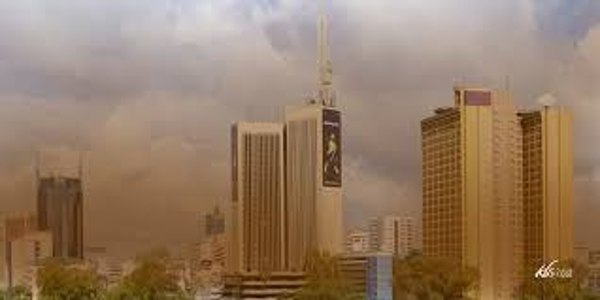

In [316]:
# Open the image
image_path = "/content/image.png"
image = Image.open(image_path)

# Resize the image
resized_image = image.resize((600, 300))

# Display the resized image
display(resized_image)

dataset containing measurements of particulate matter (PM), temperature, and humidity obtained from low-cost sensors. Particulate matter refers to tiny particles suspended in the air, which can have various sources such as combustion processes, industrial activities, and natural sources like dust and pollen. PM is often categorized based on its size, with PM2.5 (particles with a diameter of 2.5 micrometers or smaller) and PM10 (particles with a diameter of 10 micrometers or smaller) being of particular concern due to their potential health effects when inhaled

***The PM2.5 readings should ideally be kept below 12 µg/m³ for good air quality, with concentrations between 12-35 µg/m³ considered moderate, 36-55 µg/m³ unhealthy for sensitive groups, and levels exceeding 55 µg/m³ posing risks to the general population's health.***

**IMPORTANT CODES**

In [225]:
# important codes
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

### **DATA PREPARATION**

Wrangle function that does the following:


1.   Import our csv file
2.   Index to datetime and localizing timezone
3.   Subsetting only to p2.5 values
4.   Returning a dataframe




In [202]:
def wrangle(filepath):
  """Reading the file and formating it to requirements
  Parameters:
  ------------------------------------------------
  filepath:str
    csv file path to be read
  """
  # importing
  df = pd.read_csv(filepath, delimiter = ";", index_col = "timestamp")
  # to datetime
  df.index = pd.to_datetime(df.index)
  # localize timezone
  df.index = df.index.tz_convert("Africa/Nairobi")
  # subsetting p2.5(p2) particles
  df = df[df["value_type"] == "P2"]
  # having houly frequency
  df.index = pd.date_range(df.index[0], periods = len(df), freq = "H")
  # return
  return df

In [203]:
df = wrangle("/content/tmpk7avypne.csv")
df.index[:3]

DatetimeIndex(['2024-03-01 03:00:23.906433+03:00',
               '2024-03-01 04:00:23.906433+03:00',
               '2024-03-01 05:00:23.906433+03:00'],
              dtype='datetime64[ns, Africa/Nairobi]', freq='H')

### **EDA analysis**

In [118]:
# summary statistics
df["value"].describe()

count    1048.000000
mean       14.443807
std        10.186863
min         2.000000
25%         6.000000
50%        11.500000
75%        21.762500
max        69.000000
Name: value, dtype: float64

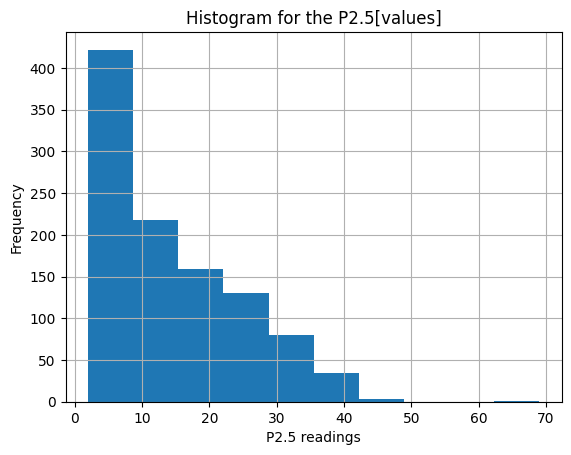

In [204]:
# creating a histogram
df["value"].hist()
plt.xlabel("P2.5 readings")
plt.ylabel("Frequency")
plt.title("Histogram for the P2.5[values]");

In [140]:
# scatter mapbox plot
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    hover_name="value_type",
    hover_data=["value"],
    width=500,
    height=500
    )

# Customize map layout
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Cities Population Map", margin={"r":0,"t":30,"l":0,"b":0})

# Show plot
fig.show()

**Note** All the observations came from the same station

In [205]:
df.head()

,sensor_id,sensor_type,location,lat,lon,value_type,value
2024-03-01 03:00:23.906433+03:00,4820,pms5003,73,-1.421,36.953,P2,9.0
2024-03-01 04:00:23.906433+03:00,4820,pms5003,73,-1.421,36.953,P2,8.5
2024-03-01 05:00:23.906433+03:00,4820,pms5003,73,-1.421,36.953,P2,8.0
2024-03-01 06:00:23.906433+03:00,4820,pms5003,73,-1.421,36.953,P2,8.0
2024-03-01 07:00:23.906433+03:00,4820,pms5003,73,-1.421,36.953,P2,10.0


In [206]:
# time series plot
fig = px.line(df["value"], title = "P2.5 values time series graph")
fig.update_layout(xaxis_title = "Monts",yaxis_title = "P2.5[Values]")
fig.show()

## **Splitting our data(X_train, y_train, X_test, y_test)**

In [207]:
# Vertical split
target = "value"
y = df[target]
X = df.drop(columns = target)
X.shape

(1048, 6)

In [ ]:
# train-test split
cutoff = int(len(df)* 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]
y_test.shape

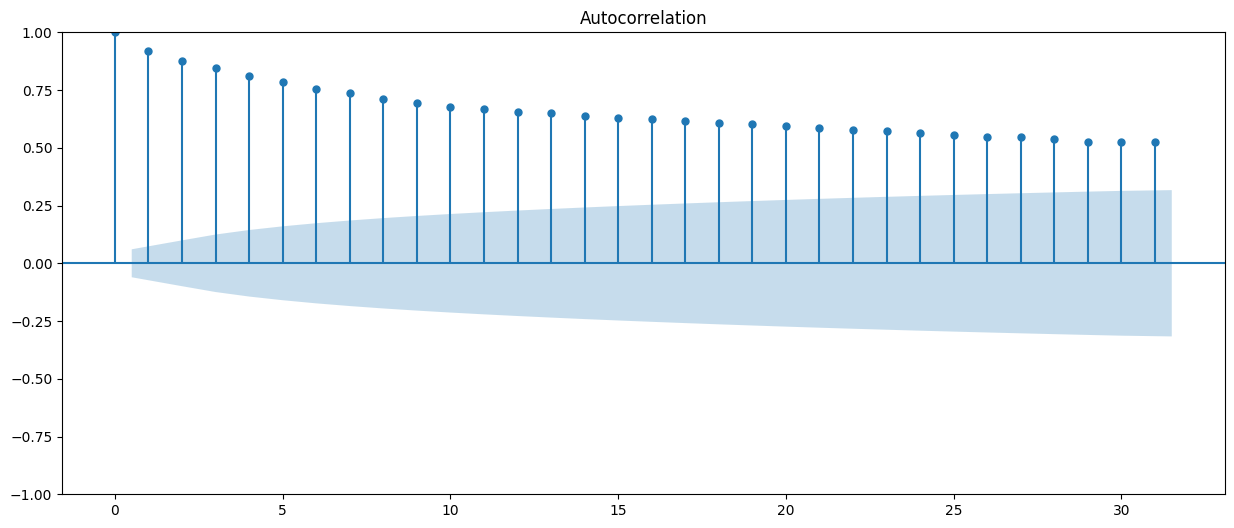

In [209]:
# pacf plots
fig, ax = plt.subplots(figsize = (15,6))
plot_acf(y, ax = ax);

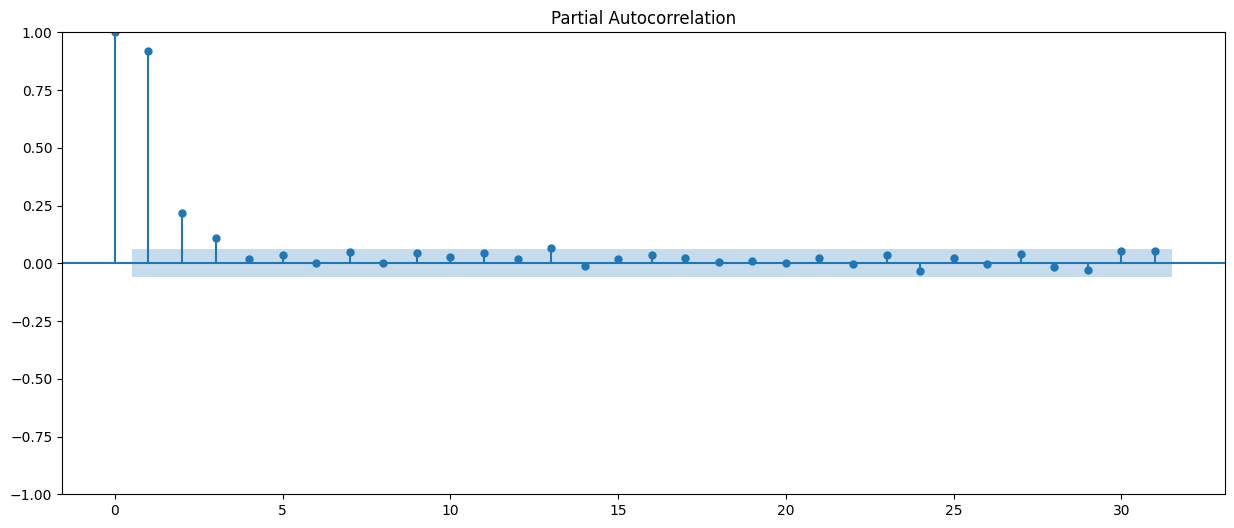

In [210]:
fig, ax = plt.subplots(figsize = (15,6))
plot_pacf(y, ax = ax);

In [230]:
# creating a lag and a correlation matrix
df["value"].corr(df["value"].shift(1))

0.9186371266983975

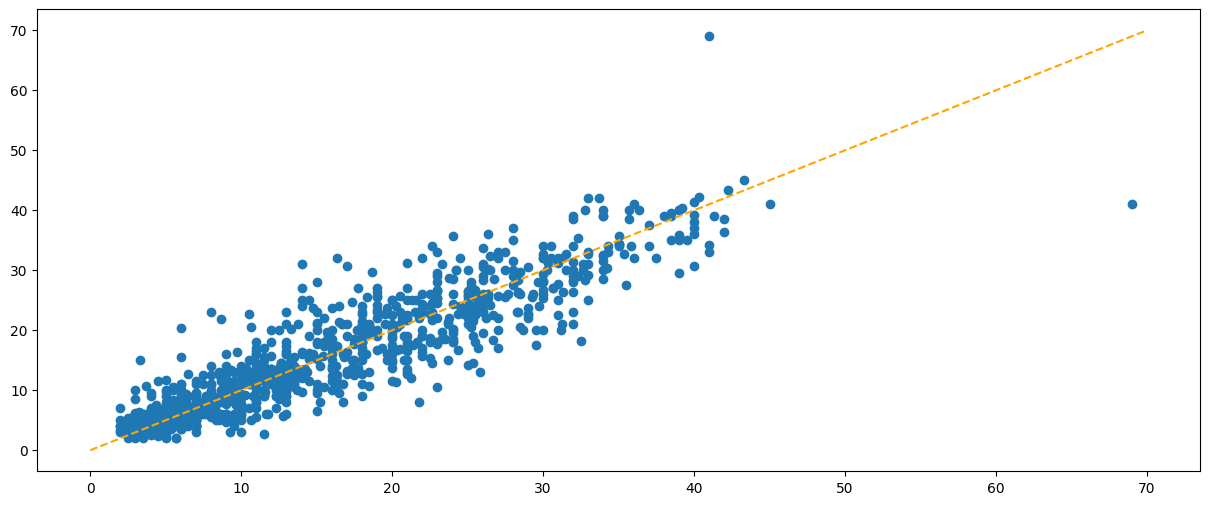

In [235]:
# autocorelation plot
fig, ax = plt.subplots(figsize = (15,6))
ax.scatter(df["value"].shift(1),df["value"])
ax.plot([0,70],[0,70], linestyle = "--", color = "orange");

## **MODEL BUILDING**

In [211]:
# model iterating
model = AutoReg(y_train, lags = 26).fit()

In [215]:
# model predictions
y_pred = model.predict().dropna()
y_pred[:5]

2024-03-02 05:00:23.906433+03:00    10.730034
2024-03-02 06:00:23.906433+03:00    13.050726
2024-03-02 07:00:23.906433+03:00     9.326980
2024-03-02 08:00:23.906433+03:00    11.683109
2024-03-02 09:00:23.906433+03:00    13.681685
Freq: H, dtype: float64

In [217]:
# calculating residuals
y_pred_resid = model.resid
y_pred_resid[:3]

2024-03-02 05:00:23.906433+03:00    2.269966
2024-03-02 06:00:23.906433+03:00   -4.050726
2024-03-02 07:00:23.906433+03:00    1.673020
Freq: H, dtype: float64

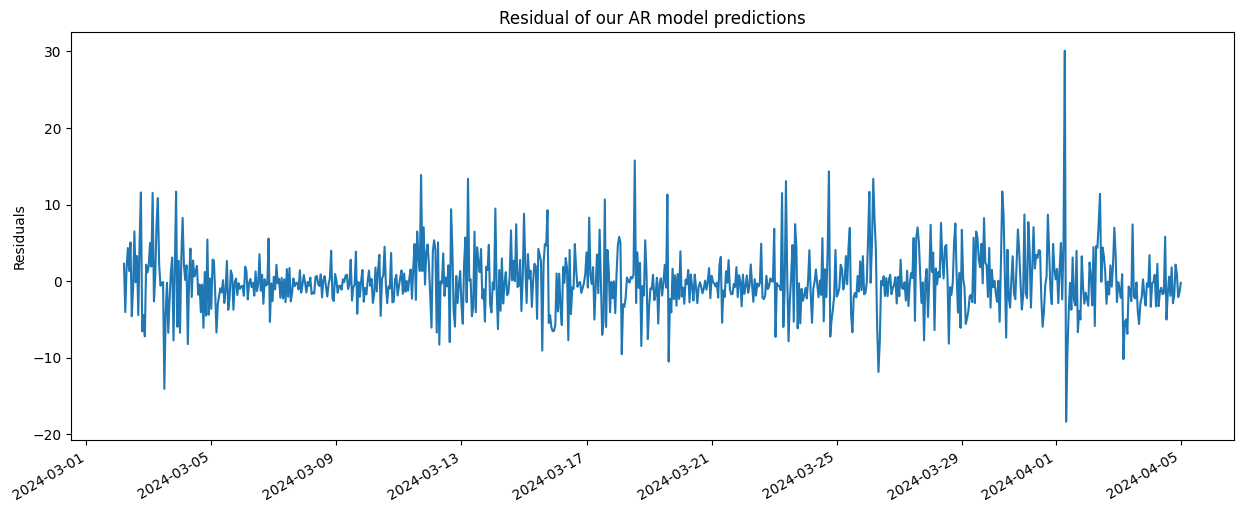

In [220]:
# plotting the residuals
fig, ax = plt.subplots(figsize = (15,6))
y_pred_resid.plot(ax = ax)
plt.ylabel("Residuals")
plt.title("Residual of our AR model predictions");

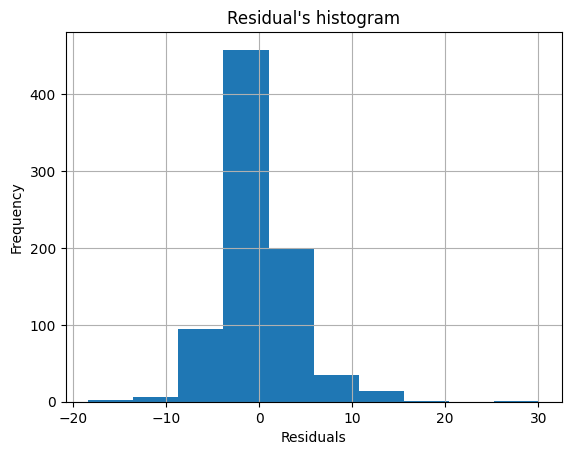

In [222]:
# a histogram of the residuals
y_pred_resid.hist()
plt.xlabel("Residuals"),
plt.ylabel("Frequency")
plt.title("Residual's histogram");

*Model Evaluation*

In [275]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
y_pred_test[:3]

2024-04-05 01:00:23.906433+03:00    6.527689
2024-04-05 02:00:23.906433+03:00    5.335392
2024-04-05 03:00:23.906433+03:00    6.045313
Freq: H, dtype: float64

In [278]:
y_train_mean = y_train.mean()
mae_baseline = mean_absolute_error(y_test, [y_train_mean]*len(y_test))
print(f"The Baseline mae is: {mae_baseline}")

The Baseline mae is: 8.56164189112399


In [279]:
mae = mean_absolute_error(y_test,y_pred_test)
print(f"The Baseline mae is: {mae_baseline}")
print(f"The MAE value for our Model Perfomance is: {mae}")

The Baseline mae is: 8.56164189112399
The MAE value for our Model Perfomance is: 2.437200100200824


*Walk forward validation*

In [265]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
# for loop
for i in range(len(y_test)):
  # modet iterate
  model = AutoReg(history, lags = 26).fit()
  # next prediction
  next_pred = model.forecast()
  y_pred_wfv = y_pred_wfv.append(next_pred)
  history = history.append(y_test[next_pred.index])

In [280]:
# walk forward mae
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print(f"The Baseline mae is: {mae_baseline}")
print(f"The MAE value for our Model Perfomance is: {mae}")
print(f"The MAE after walk forward validation is: {test_mae}")

The Baseline mae is: 8.56164189112399
The MAE value for our Model Perfomance is: 2.437200100200824
The MAE after walk forward validation is: 2.4906727594675457


In [281]:
y_pred_wfv[:3]

2024-04-05 01:00:23.906433+03:00    6.675903
2024-04-05 02:00:23.906433+03:00    5.318761
2024-04-05 03:00:23.906433+03:00    5.904208
Freq: H, dtype: float64

In [282]:
# walkforward predictions dataframe creation
y_pred_test = pd.DataFrame(
    {
        "y_test":y_test.values,
        "y_pred_wfv": y_pred_wfv.values
    }
).set_index(y_test.index)
y_pred_test[:3]

,y_test,y_pred_wfv
2024-04-05 01:00:23.906433+03:00,5.00,6.675903
2024-04-05 02:00:23.906433+03:00,5.75,5.318761
2024-04-05 03:00:23.906433+03:00,6.00,5.904208


In [286]:
fig = px.line(y_pred_test, title="AutoRegression Model prediction for the P2.5 values")
fig.update_layout(xaxis_title="Months", yaxis_title="P2.5 values")
fig.show()

## **THE END OF TIME SERIES ANALYSIS FOR AIRQUALITY IN NAIROBI**